## Packages

In [1]:
using HalfIntegers
using LinearAlgebra
using ElasticArrays
using JLD2
using Distributed
using DelimitedFiles
using Random
using CSV
using DataFrames
using LsqFit

## Plot style

In [2]:
using Plots
using Plots.PlotMeasures
using LaTeXStrings

# set backend and style
pgfplotsx()
theme(:default)
default(markerstrokewidth = 0, 
        markerstrokealpha = 0, 
        linewidth = 2, 
        #grid=:none,   
        gridlinewidth= 0.5,
        markersize = 5,
        markershape = :circle,
        tickfontsize = 18, 
        size = (900, 600), 
        legendfontsize = 18, 
        guidefontsize=20,
        titlefontsize = 20,
        legend=(0.03,0.98), 
        xticks = 0:10, 
        foreground_color_axis = "black",
        foreground_color_border = "black",
        foreground_color_guide = "darkorange",
        foreground_color_text = "black",
        guidefontcolor = "black", 
        plot_titlefontcolor = "black",
        titlefontcolor = "black", 
        shape=[:circle])
     

## Computational times

In [3]:
DATA_FOLDER = "../../data"

"../../data"

In [4]:
workers = 6
threads = 1
immirzi = 1

#comp_times = Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/computational_times/vertex_computations/immirzi_$(immirzi)_workers_$(workers)_threads_$(threads).csv", header=true)))

1

In [52]:
pl1 = plot(0:1:5, 
    [comp_times[:,9], comp_times[:,4], comp_times[:,7], comp_times[:,8], comp_times[:,5]],
    label=[L"j_0=3.5, \, j_{\pm}=1.5" L"j_0 = 4, \, j_{\pm} = 1.5" L"j_0 = 5, \, j_{\pm} = 2" L"j_0 = 5.5, \, j_{\pm} = 2"],
    markershape = :circle,    
    xticks=[0,1,2,3,4,5],
    yaxis=:log,
    legend=(0.10,0.97), 
    legendfontsize = 18)
    xlabel!(L"\Delta l")
    ylabel!(L"\textrm{seconds}")
    title!(L"\textrm{Computation time of EPRL vertices}")
savefig("./plots/laptop_comp_times_workers_$(workers)_threads_$(threads)_immirzi_$(immirzi).pdf")  

"/home/frisus/Scrivania/BlackToWhiteHole/notebooks/julia/plots/laptop_comp_times_workers_6_threads_1_immirzi_1.pdf"

## Amplitude

In [17]:
function AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

    return Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/alpha_$(alpha)/amplitude_abs_sq_T_$(T).csv", header=true)))

end

AmplitudeAbsSquaredLoad (generic function with 1 method)

In [14]:
function LifetimeLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

    return Matrix(DataFrame(CSV.File("$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/alpha_$(alpha)/lifetime_$(T).csv", header=true)))

end

LifetimeLoad (generic function with 1 method)

In [15]:
j0 = 2.0
jpm = 1.5
K0 = 0.5
Kpm = 0.5
alpha = 3
T = 100

100

In [18]:
ampls = AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, Kpm, alpha, T)

100×2 Matrix{Float64}:
 1.37798e-35  4.15618e-35
 1.40173e-35  4.21194e-35
 1.42013e-35  4.25411e-35
 1.43292e-35  4.28184e-35
 1.43991e-35  4.29453e-35
 1.44105e-35  4.29188e-35
 1.43636e-35  4.27386e-35
 1.42598e-35  4.24071e-35
 1.41012e-35  4.19294e-35
 1.38908e-35  4.13129e-35
 ⋮            
 1.05633e-35  3.39895e-35
 1.10323e-35  3.5066e-35
 1.14968e-35  3.61458e-35
 1.19491e-35  3.72081e-35
 1.23818e-35  3.82322e-35
 1.27877e-35  3.9198e-35
 1.31599e-35  4.00863e-35
 1.34924e-35  4.08795e-35
 1.37798e-35  4.15618e-35

In [25]:
ampls[:] .= ampls[:] .* 10^20

200-element view(::Vector{Float64}, :) with eltype Float64:
 1.0701739998769044e-6
 1.088620701894528e-6
 1.1029141068642849e-6
 1.1128435967821673e-6
 1.1182769500715613e-6
 1.119161069533048e-6
 1.115520790999462e-6
 1.1074558730959863e-6
 1.0951363188076719e-6
 1.0787962235084928e-6
 ⋮
 2.6397229182211356e-6
 2.7233224548507008e-6
 2.807180363597638e-6
 2.8896817239925493e-6
 2.9692178321366986e-6
 3.044223775504502e-6
 3.1132143111056983e-6
 3.174817084651679e-6
 3.227802329477877e-6

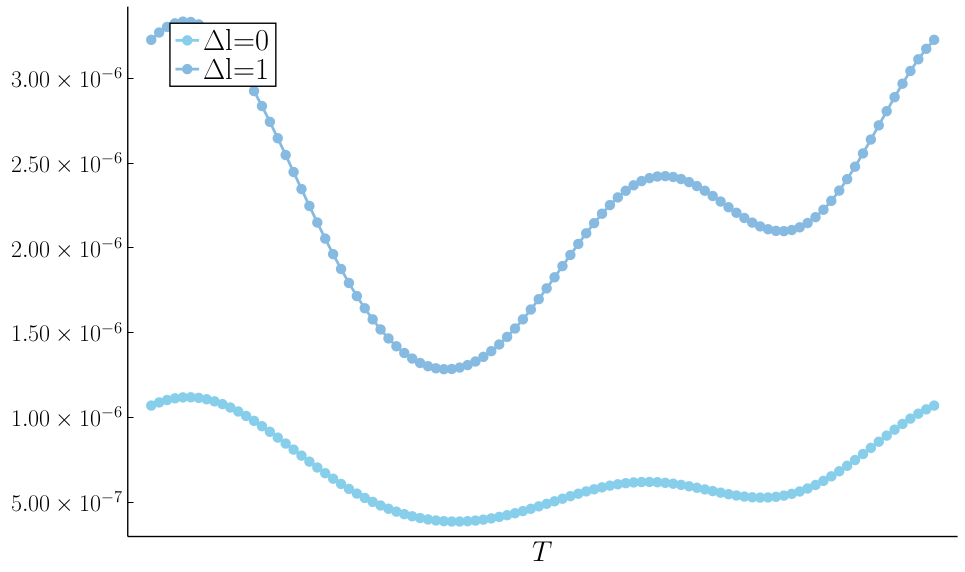

In [26]:
final_x_tick = 100

pl1 = plot(0:99, 
    [ampls[:, 1] ampls[:, 2]],
    label=["Δl=0" "Δl=1"],
    markershape = :circle,    
    grid=:false,
    xticks = (120, round(final_x_tick, digits=3)),
    legend=(0.05,0.97), 
    #palette = palette([:skyblue, :royalblue2, :blue]),
    palette = palette([:skyblue, :purple], 11),
    legendfontsize = 22)
    xlabel!(L"T")
    #title!(L"|W  \, \left(m=1.225, \, \alpha=%immirzi \right) |")
#savefig("(store_folder)/W_alpha_(alpha)_Immirzi_$(immirzi)_m_first.pdf")

In [28]:
ampls = AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, K0, 0.0, alpha, T)

100×2 Matrix{Float64}:
 1.9967e-41   7.25977e-41
 1.98105e-41  7.19886e-41
 1.93465e-41  7.01836e-41
 1.85919e-41  6.72478e-41
 1.7574e-41   6.32873e-41
 1.63295e-41  5.84452e-41
 1.49033e-41  5.28966e-41
 1.33472e-41  4.68421e-41
 1.17172e-41  4.05003e-41
 1.00723e-41  3.41007e-41
 ⋮            
 1.17172e-41  4.05003e-41
 1.33472e-41  4.68421e-41
 1.49033e-41  5.28966e-41
 1.63295e-41  5.84452e-41
 1.7574e-41   6.32873e-41
 1.85919e-41  6.72478e-41
 1.93465e-41  7.01836e-41
 1.98105e-41  7.19886e-41
 1.9967e-41   7.25977e-41

In [30]:
ampls[:] .= ampls[:] .* 10^20

200-element view(::Vector{Float64}, :) with eltype Float64:
 0.001204311767381451
 0.0011948704345339746
 0.0011668876703598084
 0.0011213748448645883
 0.001059976910144222
 0.0009849129475302605
 0.0008988959642088196
 0.0008050348380722014
 0.0007067219547717615
 0.0006075105980616964
 ⋮
 0.002442782182700372
 0.002825284265136222
 0.003190466070427353
 0.0035251289766586235
 0.0038171773944431476
 0.004056055933037456
 0.004233130899664783
 0.004342002343666899
 0.004378735367395787

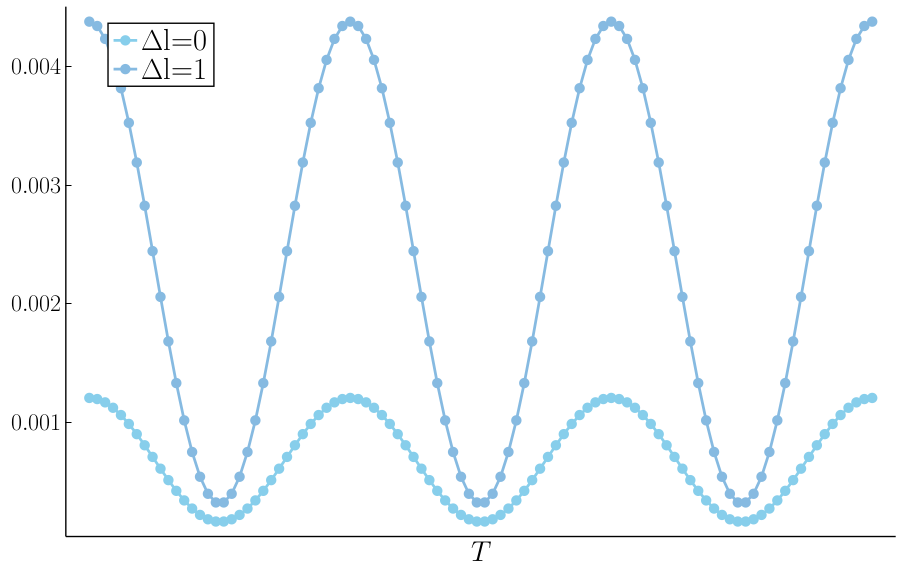

In [31]:
final_x_tick = 100

pl1 = plot(0:99, 
    [ampls[:, 1] ampls[:, 2]],
    label=["Δl=0" "Δl=1"],
    markershape = :circle,    
    grid=:false,
    xticks = (120, round(final_x_tick, digits=3)),
    legend=(0.05,0.97), 
    #palette = palette([:skyblue, :royalblue2, :blue]),
    palette = palette([:skyblue, :purple], 11),
    legendfontsize = 22)
    xlabel!(L"T")
    #title!(L"|W  \, \left(m=1.225, \, \alpha=%immirzi \right) |")
#savefig("(store_folder)/W_alpha_(alpha)_Immirzi_$(immirzi)_m_first.pdf")